In [147]:
# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [149]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.2.0-rc4


In [0]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

**Get the data**

---


Read toefl data from project repositoy

In [151]:
df = pd.read_csv('https://raw.githubusercontent.com/xiaomeng-ma/AES-Project/master/TOEFL_11/processed_toefl.csv?token=AKHHIKGFAQEH3F5HSPWHYTC6WNOXG')
df.head()

,Prompt,Language,Score Level,total word,distance,Hpoint,xmin,alpha,mu,sigma,logtrue,file,pl_s,pl_C,pl_R2,log_d,log_m,log_k,log_R2
0,5,6,high,385,6.000000,8,2.0,2.273182,-10.388887,3.025490,0,88,0.626725,27.346485,0.883300,3.478245,0.639538,1.090635,0.869275
1,5,1,medium,321,11.000000,7,3.0,2.421178,-2.618379,1.817156,0,278,0.720874,31.641664,0.962596,3.573915,0.757765,1.032666,0.951214
2,0,9,high,363,8.306624,6,2.0,2.398038,-2.825649,1.739209,0,348,0.621470,21.737883,0.965709,3.352892,0.874682,0.849857,0.889519
3,1,10,medium,362,4.690416,6,5.0,3.410995,0.835672,0.746383,0,666,0.538645,18.320499,0.924139,2.824981,0.296708,1.441791,0.969115
4,5,8,medium,344,10.630146,7,6.0,3.124099,-0.359383,1.163868,0,733,0.646729,25.998149,0.938335,3.393319,0.638436,1.093227,0.926643


**Convert Target column to numberic**

In [152]:
score_mapping ={
    'low':0,
    'medium':1,
    'high': 2
}
inv_score_mapping = {v: k for k, v in score_mapping.items()}
df['Score Level'] = df['Score Level'].map(score_mapping)
df.head()

,Prompt,Language,Score Level,total word,distance,Hpoint,xmin,alpha,mu,sigma,logtrue,file,pl_s,pl_C,pl_R2,log_d,log_m,log_k,log_R2
0,5,6,2,385,6.000000,8,2.0,2.273182,-10.388887,3.025490,0,88,0.626725,27.346485,0.883300,3.478245,0.639538,1.090635,0.869275
1,5,1,1,321,11.000000,7,3.0,2.421178,-2.618379,1.817156,0,278,0.720874,31.641664,0.962596,3.573915,0.757765,1.032666,0.951214
2,0,9,2,363,8.306624,6,2.0,2.398038,-2.825649,1.739209,0,348,0.621470,21.737883,0.965709,3.352892,0.874682,0.849857,0.889519
3,1,10,1,362,4.690416,6,5.0,3.410995,0.835672,0.746383,0,666,0.538645,18.320499,0.924139,2.824981,0.296708,1.441791,0.969115
4,5,8,1,344,10.630146,7,6.0,3.124099,-0.359383,1.163868,0,733,0.646729,25.998149,0.938335,3.393319,0.638436,1.093227,0.926643


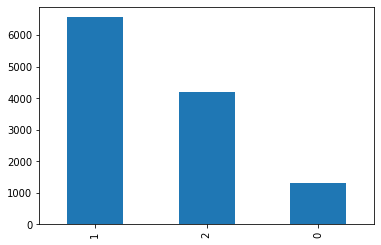

In [153]:
df['Score Level'].value_counts().plot(kind='bar')

**Divide variables into independent variables and a dependent variable**

In [0]:
X, y = df.drop(['Score Level'],axis=1), df['Score Level']

**Normalize the data using Standard Scaler**

In [0]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(X)

**Divide the data into a test and training set**

In [156]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123,stratify=y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9678, 18) (9678,) (2420, 18) (2420,)


**Define a deep learning model**

In [0]:
model = keras.Sequential([
    layers.Dense(1000, activation='relu', input_shape=[X.shape[1]]),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(3)
  ])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy','mae', 'mse'])



**Fit model with Train data with validation split 0.2**

In [158]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)

history = model.fit(X_train, y_train, validation_split = 0.2, callbacks=[early_stop, tfdocs.modeling.EpochDots()], epochs=100)

Epoch 1/100
240/242 [============================>.] - ETA: 0s - loss: 0.7829 - accuracy: 0.6318 - mae: 1.3778 - mse: 3.2556
Epoch: 0, accuracy:0.6323,  loss:0.7822,  mae:1.3795,  mse:3.2665,  val_accuracy:0.6663,  val_loss:0.6886,  val_mae:1.3680,  val_mse:3.5639,  
242/242 [==============================] - 1s 5ms/step - loss: 0.7822 - accuracy: 0.6323 - mae: 1.3795 - mse: 3.2665 - val_loss: 0.6886 - val_accuracy: 0.6663 - val_mae: 1.3680 - val_mse: 3.5639
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7218 - accuracy: 0.6649 - mae: 1.5947 - mse: 4.8362 - val_loss: 0.6702 - val_accuracy: 0.6890 - val_mae: 1.5868 - val_mse: 5.0986
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6992 - accuracy: 0.6803 - mae: 1.7613 - mse: 6.4738 - val_loss: 0.6612 - val_accuracy: 0.6885 - val_mae: 1.6761 - val_mse: 5.9922
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6928 - accuracy: 0.6810 - mae: 1.8614 - mse: 7

Text(0, 0.5, 'accuracy')

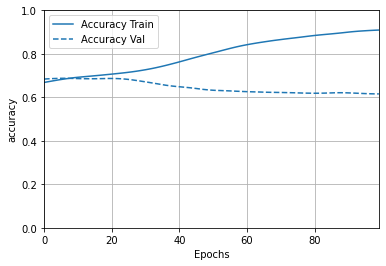

In [159]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Accuracy': history}, metric = "accuracy")
plt.ylim([0, 1])
plt.ylabel('accuracy')

Text(0, 0.5, 'loss')

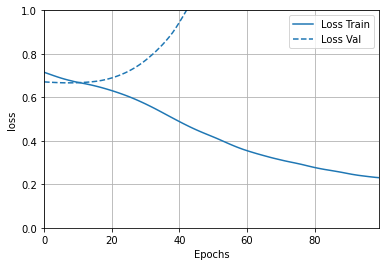

In [160]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Loss': history}, metric = "loss")
plt.ylim([0, 1])
plt.ylabel('loss')

In [161]:
loss, accuracy ,mae, mse = model.evaluate(X_test, y_test, verbose=2)

print("Test set loss: {:5.2f} , accuracy: {:5.2f}, mae: {:5.2f}, mse: {:5.2f}  ".format(loss, accuracy, mae, mse))

76/76 - 0s - loss: 2.8438 - accuracy: 0.6401 - mae: 11.3527 - mse: 568.4963
Test set loss:  2.84 , accuracy:  0.64, mae: 11.35, mse: 568.50  


**The Classification Report for Model**  precision    recall  f1-score   support

In [162]:
from sklearn import metrics
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

target_names = ['low', 'medium', 'high']
print(metrics.classification_report(y_test, y_pred, digits=3, target_names=target_names))

              precision    recall  f1-score   support

         low      0.607     0.523     0.562       266
      medium      0.675     0.676     0.676      1314
        high      0.596     0.621     0.608       840

    accuracy                          0.640      2420
   macro avg      0.626     0.607     0.615      2420
weighted avg      0.640     0.640     0.640      2420



**The Kappa Score for Model**

In [163]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score
print('Kappa Score {:5.5f}'.format(cohen_kappa_score(y_test, y_pred, weights='quadratic')))

Kappa Score 0.36735


Code Reference 


1.   https://www.tensorflow.org/tutorials/keras/regression
2.   List item

